# Data Extraction
### code from `data_loader_demo.ipynb`

In [27]:
%load_ext autoreload
%autoreload 2

import warnings

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Exploration
import matplotlib.pyplot as plt

# Feature Engineering
import numpy as np
import pandas as pd

import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
import params as p

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

from xgboost import XGBClassifier

import optuna
from optuna.integration import XGBoostPruningCallback

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Settings

In [28]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Financial Phrasebank

In [3]:
# The financial_phrasebank dataset is available in four variations. It has no predefined train/validation/test splits.
# Each data point was annotated by 5-8 people, then their annotations were combined. 
# Each variation of the dataset contains examples with different levels of agreement. 
# Let's use the one containing all data points where at least 50% of the annotators agreed on the label.
dataset = load_dataset(
    "financial_phrasebank", 
    'sentences_50agree' # Select variation of the dataset
)

print(f'The dataset is a dictionary with two splits: \n\n{dataset}')

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 53.17it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [4]:
# Split test data from training data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    dataset["train"]['sentence'], 
    dataset["train"]['label'], 
    test_size=0.2, 
    stratify=dataset["train"]['label']  # make sure the same proportion of labels is in the test set and training set
)

In [5]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_sentences)}')
print('')
print(f'What does one instance look like? \n\n{train_sentences[234]}')

How many instances in the train dataset? 

3876

What does one instance look like? 

The company is headquartered in Sievi , Finland , and is listed on the Nordic Exchange in Helsinki .


It may also be necessary to create a _validation_ set (also called 'development' set or 'devset'). The validation set can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specifso it gets good performance on the test set examples. 

In [6]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.25, stratify=train_labels)


In [7]:
print(f'How many instances in the validation dataset? \n\n{len(val_sentences)}\n')
print(f'How many instances in the test dataset? \n\n{len(test_sentences)}')

How many instances in the validation dataset? 

969

How many instances in the test dataset? 

970


# Data Exploration

In [8]:
train = pd.DataFrame({'sentences' : train_sentences, 'labels' : train_labels})

## Very Brief Response Analysis

Should only need to do this for train due to random split. So would expect to see the same structure for test and val

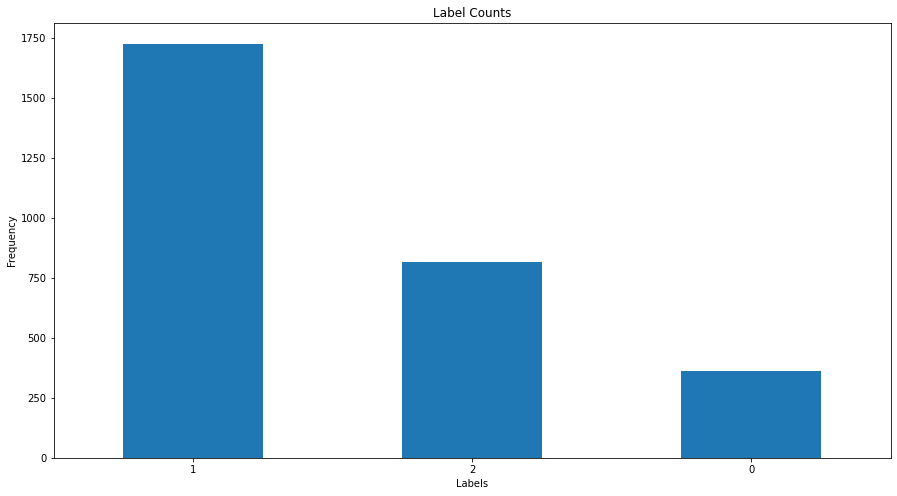

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

ax = train.labels.value_counts().plot(kind='bar', title = 'Label Counts')

ax.set_xlabel("Labels")
ax.set_ylabel("Frequency")
plt.xticks(rotation = 0)

plt.show()

Slight Imbalance of labels, but nothing that will be an issue

# Featuring Engineering

### Sentence Processing

In [10]:
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

# load up a simple porter stemmer - nothing fancy
ps = nltk.porter.PorterStemmer()

def simple_text_preprocessor(document): 
    # lower case
    document = str(document).lower()
    
    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub(r'nbsp', r'', document)
    document = re.sub(' +', ' ', document)
    
    # simple porter stemming
    document = ' '.join([ps.stem(word) for word in document.split()])
    
    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

stp = np.vectorize(simple_text_preprocessor)

In [11]:
clean_train_sentences = stp(train_sentences)
clean_test_sentences = stp(test_sentences)
clean_val_sentences = stp(val_sentences)

In [12]:
tfidf = TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (1, 2))

In [13]:
X_train = tfidf.fit_transform(clean_train_sentences).toarray()
X_train = pd.DataFrame(X_train, columns = tfidf.get_feature_names_out())

X_test = tfidf.transform(clean_test_sentences).toarray()
X_test = pd.DataFrame(X_test, columns = tfidf.get_feature_names_out())

X_val = tfidf.transform(clean_val_sentences).toarray()
X_val = pd.DataFrame(X_val, columns = tfidf.get_feature_names_out())

In [14]:
X_train.head()

,aaland,aaland island,aalborg,aalborg northern,aava,aava mobil,ab,ab acanb,ab crown,ab finnish,...,zoltan krippl,zone,zone plan,zone villag,zoo,zoo poland,zte,zte corp,zu,zu beeinflussen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [15]:
y_train = train_labels
y_test = test_labels
y_val = val_labels

In [17]:
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

In [45]:
def evaluate_model(model, X, y):

    y_pred = model.predict(X)
    y_pred_probs = model.predict_proba(X)

    print('ROC AUC Score:\t', roc_auc_score(y, y_pred_probs, average = 'macro', multi_class='ovr'))

    print('--- MACRO ---')
    print(f'Accuracy:\t', accuracy_score(y, y_pred))
    print(f'Precision:\t', precision_score(y, y_pred, average='macro'))
    print(f'Recall:\t\t', recall_score(y, y_pred, average='macro'))
    print(f'F1 score:\t', f1_score(y, y_pred, average='macro'))

    # We can get all of these with a per-class breakdown using classification_report:
    print(classification_report(y, y_pred))

### Naive Bayes

In [46]:
nb = MultinomialNB().fit(**train_data)

In [47]:
evaluate_model(nb, **test_data)

ROC AUC Score:	 0.8064821047757649
--- MACRO ---
Accuracy:	 0.654639175257732
Precision:	 0.7483145339037988
Recall:		 0.41882218160627255
F1 score:	 0.4004735218751297
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       121
           1       0.66      0.98      0.79       576
           2       0.58      0.23      0.33       273

    accuracy                           0.65       970
   macro avg       0.75      0.42      0.40       970
weighted avg       0.68      0.65      0.57       970



In [26]:
xgb = XGBClassifier(random_state = p.RANDOM_STATE).fit(**train_data)

/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:01:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
evaluate_model(xgb, **test_data)

ROC AUC Score:	 0.855167658141454
--- MACRO ---
Accuracy:	 0.7381443298969073
Precision:	 0.7137313432835821
Recall:		 0.6540325205097932
F1 score:	 0.6757188665610251
              precision    recall  f1-score   support

           0       0.70      0.58      0.63       121
           1       0.76      0.89      0.82       576
           2       0.68      0.50      0.58       273

    accuracy                           0.74       970
   macro avg       0.71      0.65      0.68       970
weighted avg       0.73      0.74      0.73       970



In [30]:
xgb_base_params = {
    'objective' : 'multi:softprob', 
    'learning_rate' : 0.1,
    'verbosity' : 0,
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

def xgb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = xgb_base_params):

    obj_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 7),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'subsample' : trial.suggest_float('subsample', 0.1, 1),

        **base_params
        }

    pruning_callback = XGBoostPruningCallback(trial, observation_key = 'validation_1-rmse')

    xgb_obj = XGBClassifier(**obj_params)
    xgb_obj.fit(
        X_train,
        y_train,
        eval_metric = 'auc',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = obj_params['n_estimators'] * 0.1,
        verbose = 0,
        callbacks = [pruning_callback]
        )

    y_pred = xgb_obj.predict_proba(X_test)

    roc = roc_auc_score(y_true=y_test, y_score=y_pred, multi_class='ovr')
    
    return roc

xgb_study = optuna.create_study(direction = 'maximize')
xgb_study.optimize(xgb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-25 17:06:53,269] A new study created in memory with name: no-name-7ac4b304-521f-4b0e-8ae4-e5a4e53da606
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[W 2022-03-25 17:07:35,060] Trial 0 failed because of the following error: XGBoostError('[17:07:34] ../src/metric/elementwise_metric.cu:365: Check failed: preds.Size() == info.labels_.Size() (8721 vs. 2907) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification\nStack trace:\n  [bt] (0) 1   libxgboost.dylib                    0x0000000175dcba54 dmlc::LogMessageFatal

KeyboardInterrupt: 

[W 2022-03-25 17:14:56,704] Trial 6 failed because of the following error: XGBoostError('[17:14:55] ../src/metric/elementwise_metric.cu:365: Check failed: preds.Size() == info.labels_.Size() (8721 vs. 2907) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification\nStack trace:\n  [bt] (0) 1   libxgboost.dylib                    0x0000000175dcba54 dmlc::LogMessageFatal::~LogMessageFatal() + 116\n  [bt] (1) 2   libxgboost.dylib                    0x0000000175ea4c1a xgboost::metric::EvalEWiseBase<xgboost::metric::EvalRowRMSE>::Eval(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, bool) + 298\n  [bt] (2) 3   libxgboost.dylib                    0x0000000175e7cc03 xgboost::LearnerImpl::EvalOneIter(int, std::__1::vector<std::__1::shared_ptr<xgboost::DMatrix>, std::__1::allocator<std::__1::shared_ptr<xgboost::DMatrix> > > const&, std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, st

In [ ]:
xgb_tuned_params = {**xgb_study.best_params, **xgb_base_params}
xgb_tuned_params

In [ ]:
xgb_tuned = XGBClassifier(**xgb_tuned_params)
xgb_tuned.fit(
    **train_data,
    eval_metric = 'auc',
    eval_set = [(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds = xgb_tuned_params['n_estimators'] * 0.1,
    verbose = 0
    )

In [ ]:
evaluate_model(xgb_tuned, **test_data)

MACRO
Accuracy:	 0.7206185567010309
Precision:	 0.702044044044044
Recall:		 0.575268008506645
F1 score:	 0.6060845944585984
              precision    recall  f1-score   support

           0       0.64      0.38      0.48       121
           1       0.72      0.94      0.82       576
           2       0.74      0.40      0.52       273

    accuracy                           0.72       970
   macro avg       0.70      0.58      0.61       970
weighted avg       0.72      0.72      0.69       970



## NB

In [ ]:
def nb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    obj_params = {
        'alpha' : trial.suggest_uniform('alpha', 0.2, 2),
        'fit_prior' : trial.suggest_categorical('fit_prior', [True, False])
    }

    nb_obj = MultinomialNB(**obj_params)
    nb_obj.fit(X_train, y_train)

    y_pred = nb_obj.predict_proba(X_test)

    roc = roc_auc_score(y_true = y_test, y_pred = y_pred, average = 'macro', multi_class='ovr')
    
    return roc

nb_study = optuna.create_study(direction='maximize')
nb_study.optimize(nb_objective, n_trials = 200, n_jobs = -1)

In [ ]:
nb_tuned_params = nb_study.best_params.copy()

### Post-tuned Performance

In [21]:
evaluate_model(rf, **val_data)

MACRO
Accuracy:	 0.7058823529411765
Precision:	 0.6759885039511749
Recall:		 0.5425576509299771
F1 score:	 0.5704572342069808
              precision    recall  f1-score   support

           0       0.67      0.31      0.43       121
           1       0.72      0.95      0.82       576
           2       0.64      0.36      0.46       272

    accuracy                           0.71       969
   macro avg       0.68      0.54      0.57       969
weighted avg       0.69      0.71      0.67       969



In [22]:
feature_importances = {x : y for x, y in zip(rf.feature_names_in_, rf.feature_importances_)}